In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, Conv1D, Input, Reshape, Dense, Flatten
from keras.layers import BatchNormalization, Activation, AveragePooling1D
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
import pickle

import itertools
from sklearn import metrics
from  sklearn.metrics import roc_auc_score


In [2]:
path = './data_twoclass/'

In [3]:
xtrain = np.load(path + 'train_features.npy')
ytrain = np.load(path + 'train_labels.npy')

xval = np.load(path + 'val_features.npy')
yval = np.load(path + 'val_labels.npy')

xtest = np.load(path + 'test_features.npy')
ytest = np.load(path + 'test_labels.npy')

In [4]:
#### Model ####
reg = l2(.001)

X = Input(batch_shape = (None, 60, 41, 2))

conv1 = Conv2D(128, (3, 41), strides = (1,41), padding = 'same', 
               kernel_initializer = 'he_normal', kernel_regularizer = reg)(X)
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)

reshape = Reshape((60,128))(act1)

conv2 = Conv1D(256, 3, strides = 1, padding = 'same', 
               kernel_initializer = 'he_normal', kernel_regularizer = reg)(reshape)
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)

pool = AveragePooling1D(pool_size = act2.get_shape().as_list()[1], 
                        strides=1, padding='valid')(act2)

flat = Flatten()(pool)
d = Dense(2, kernel_initializer='he_normal', kernel_regularizer = reg)(flat)
bn_d = BatchNormalization()(d)
Yhat = Activation('softmax')(bn_d)

model = Model(X, Yhat)

#### Training Set Up ####

weight_dict = {0: float(ytrain[ytrain[:,0]==1].shape[0])/ytrain[ytrain[:,0]==1].shape[0],
               1: float(ytrain[ytrain[:,0]==1].shape[0])/ytrain[ytrain[:,1]==1].shape[0]}

lr = 1e-3                                                                                                                                                     
dcy = 2e-4
m = 0.9                                                                                                                                                                           
sgd = SGD(lr=lr, momentum=m, decay=dcy,  nesterov=True)

name = './history/model1_lr%.1ef_dcy%.2f_m%.2f' % (lr, dcy, m)
checkpointer = ModelCheckpoint(filepath = name + '_{epoch:03d}-{val_acc:.2f}.h5',
                               monitor = 'val_acc', verbose=0, save_best_only=True)

model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])




In [5]:
### Training Model ###
a = model.fit(xtrain, ytrain, batch_size=512, epochs=500, verbose=1, 
          validation_data= (xval, yval), class_weight=weight_dict)

Train on 513 samples, validate on 70 samples
Epoch 1/500
513/513 [==============================] - 2s - loss: 1.1641 - acc: 0.3840 - val_loss: 5.2214 - val_acc: 0.3714
Epoch 2/500
513/513 [==============================] - 0s - loss: 0.6481 - acc: 0.6881 - val_loss: 5.0799 - val_acc: 0.3714
Epoch 3/500
513/513 [==============================] - 0s - loss: 0.6010 - acc: 0.8012 - val_loss: 5.2202 - val_acc: 0.3714
Epoch 4/500
513/513 [==============================] - 0s - loss: 0.5908 - acc: 0.8538 - val_loss: 5.2286 - val_acc: 0.3714
Epoch 5/500
513/513 [==============================] - 0s - loss: 0.5848 - acc: 0.8655 - val_loss: 5.0115 - val_acc: 0.3714
Epoch 6/500
513/513 [==============================] - 0s - loss: 0.5773 - acc: 0.8811 - val_loss: 4

In [6]:
### Saving History ###
with open('history.pkl', 'wb') as f:
    pickle.dump(a.history, f)

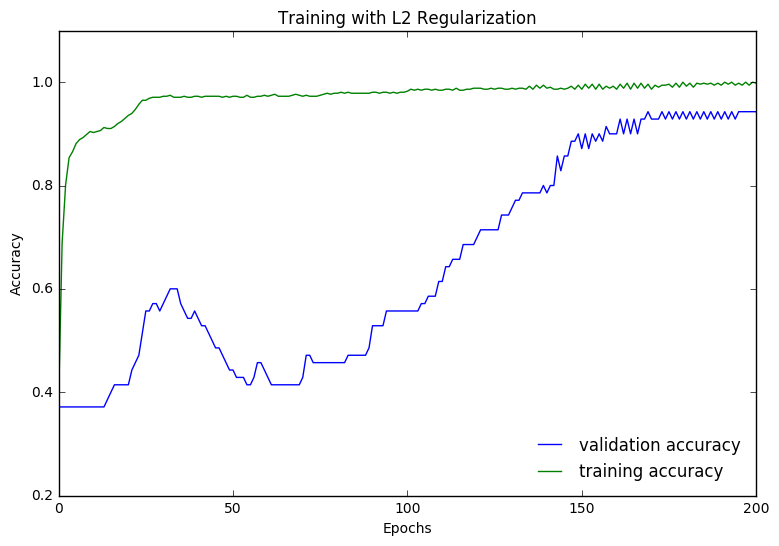

In [7]:
# Graphing History
with open('history.pkl', 'rb') as f:
    a = pickle.load(f)


fig = plt.figure(figsize=(9,6))
plt.plot(a['val_acc'], label = 'validation accuracy')
plt.plot(a['acc'], label = 'training accuracy')
plt.axis([0,200,.2, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training with L2 Regularization')
plt.legend(loc = 4, frameon = 0)

plt.show()

In [28]:
def one_hot(labels):
    n_values = len(np.unique(labels))
    return np.eye(n_values)[labels]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size='xx-large')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def draw_weight(layer):
    filter_weights = np.array(model.layers[layer].get_weights())[0]
    arr_filters = np.zeros(filter_weights[:,:,0,0].shape)
    channels = filter_weights.shape[2]
    num_filters = filter_weights.shape[3]
    fig, axes = plt.subplots(1, 4, figsize=(10, 10))
    count = 0
    for i in range(2):
        for j in range(2):
            temp = filter_weights[:,:,j,i]
            arr_filters = np.concatenate((arr_filters, temp))
            axes[count].imshow(temp, interpolation='bilinear')
            count += 1
#     return arr_filters

In [10]:
i = 0
for layer in model.layers:
    print "{}: {}".format(i,layer)
    i += 1

0: <keras.engine.topology.InputLayer object at 0x2aab0d35e3d0>
1: <keras.layers.convolutional.Conv2D object at 0x2aab0d35e450>
2: <keras.layers.normalization.BatchNormalization object at 0x2aaaba745890>
3: <keras.layers.core.Activation object at 0x2aab0d394d10>
4: <keras.layers.core.Reshape object at 0x2aab0d3a2a50>
5: <keras.layers.convolutional.Conv1D object at 0x2aab0ecdfe50>
6: <keras.layers.normalization.BatchNormalization object at 0x2aab0d441e50>
7: <keras.layers.core.Activation object at 0x2aab0d3afd10>
8: <keras.layers.pooling.AveragePooling1D object at 0x2aab0eda6e90>
9: <keras.layers.core.Flatten object at 0x2aab0d3fefd0>
10: <keras.layers.core.Dense object at 0x2aab0ed79cd0>
11: <keras.layers.normalization.BatchNormalization object at 0x2aab0edc5810>
12: <keras.layers.core.Activation object at 0x2aab0ee94f90>


In [11]:
y_test = ytest
y_pred = model.predict(xtest)
CLASS = ['Walrus','White-sided Dolphin']

Confusion matrix, without normalization
[[31 15]
 [ 0 25]]


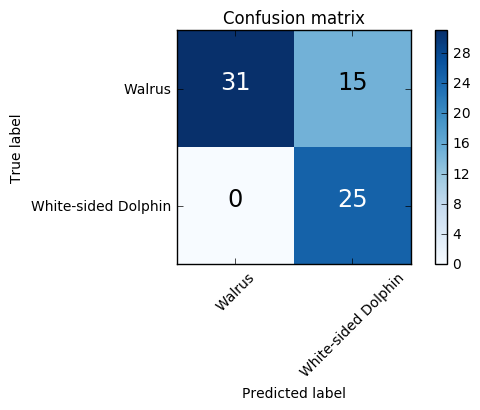

In [16]:
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)
conf_mat = metrics.confusion_matrix(y_test_class, y_pred_class)
plot_confusion_matrix(conf_mat, classes=CLASS)

In [17]:
# Compute ROC curve and ROC area for each class
n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

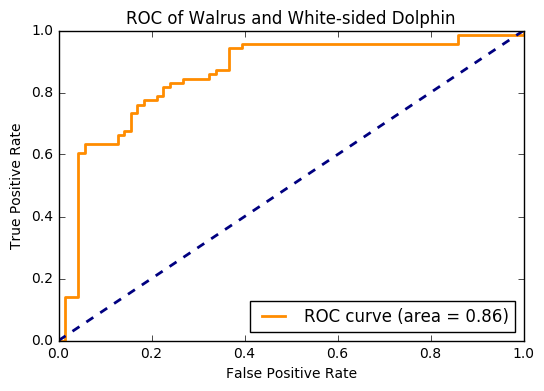

In [18]:
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of {} and {}'.format(CLASS[0], CLASS[1]))
plt.legend(loc="lower right")
plt.show()

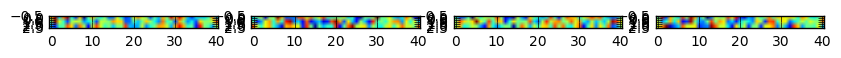

In [29]:
draw_weight(1)